In [1]:
import os
from dotenv import load_dotenv
import praw
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
load_dotenv() # Load environment variables 

reddit_client_id = os.getenv("REDDIT_CLIENT_ID")
reddit_client_secret = os.getenv("REDDIT_CLIENT_SECRET")
reddit_user_agent = os.getenv("REDDIT_APP_NAME")
reddit_client_username = os.getenv("REDDIT_USER_NAME")
reddit_client_password = os.getenv("REDDIT_PASS_WORD")


In [3]:
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent=reddit_user_agent)

In [5]:
# Vaccine & Immunization Keywords
vaccine_keywords = [
    "vaccine", "vaccination", "immunization", "booster",
    "vaccine safety", "vaccine efficacy", "jab", "shot","pro-vax","anti-vax","vaccine hesitancy"
]

# Mask & Face Covering Keywords
mask_keywords = [
    "mask", "face mask", "face covering", "N95", "surgical mask",
    "cloth mask", "mask mandate"
]

# Public Health & Safety Keywords
public_health_keywords = [
    "public health", "health safety", "pandemic", "outbreak", "community health",
    "virus", "COVID-19", "prevention", "social distancing", "flatten the curve"
]

keywords = vaccine_keywords + mask_keywords + public_health_keywords


In [ ]:
subreddit = reddit.subreddit('all')


posts_data = []


for keyword in keywords:
    for submission in subreddit.search(keyword, limit=10):  # 10 post per keyword
        post_info = {
            'id': submission.id,
            'title': submission.title,
            'selftext': submission.selftext,
            'url': submission.url,
            'created': submission.created_utc,
            'comments': []
        }
        
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            post_info['comments'].append({
                'id': comment.id,
                'body': comment.body,
                'created': comment.created_utc
            })
        posts_data.append(post_info)

with open('reddit_data.json', 'w', encoding='utf-8') as f:
    json.dump(posts_data, f, ensure_ascii=False, indent=4)

Total posts related public health in 2024-25 based on the chosen key words:  186
Number of empty selftext posts (non textual media shared): 97
Total posts related public health in 2024-25 based on the chosen key words (after removing other forms of media):  89
Date with maximum posts: 2025-03 with 27 posts.
Date with maximum posts: 2025-03-26 00:00:00 with 4 posts.


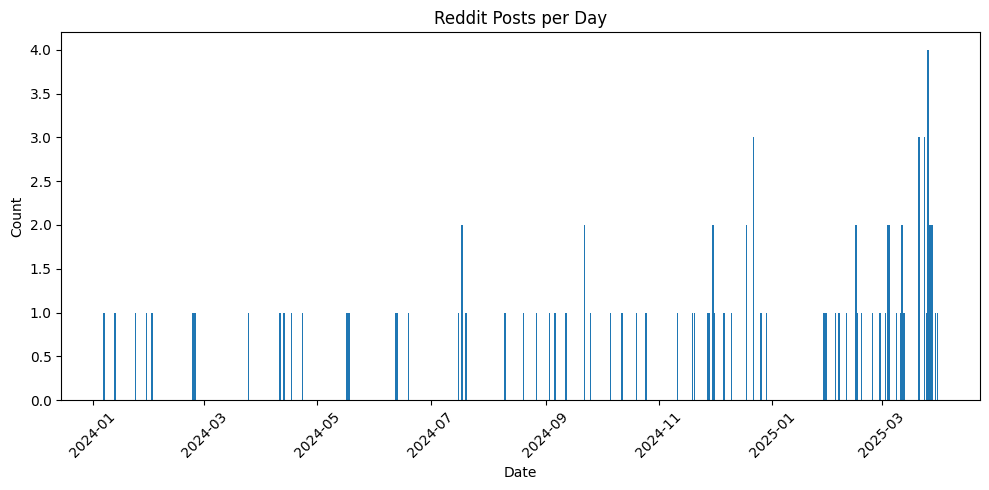

In [50]:
with open('reddit_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

df['created'] = pd.to_datetime(df['created'], unit='s')

df.set_index('created', inplace=True) # Make date index

df = df[(df.index.year == 2024) | (df.index.year == 2025)]
print("Total posts related public health in 2024-25 based on the chosen key words: ",len(df)) # Post Count

print("Number of empty selftext posts (non textual media shared):",(df['selftext'] == '').sum())
df = df[df['selftext'] != '']
print("Total posts related public health in 2024-25 based on the chosen key words (after removing other forms of media): ",len(df)) # Post Count


monthly_posts = df.resample('ME').size() # Daily posts
monthly_posts.index = monthly_posts.index.strftime('%Y-%m')  #Converting year-nmoth format
max_date = monthly_posts.idxmax()  # This returns the date with the highest post count
max_count = monthly_posts[max_date]  # This returns the count at that date
print("Date with maximum posts:", max_date, "with", max_count, "posts.")


daily_posts = df.resample('D').size() # Daily posts
max_date = daily_posts.idxmax()
max_count = daily_posts[max_date]
print("Date with maximum posts:", max_date, "with", max_count, "posts.")



plt.figure(figsize=(10, 5))
plt.bar(daily_posts.index, daily_posts.values)
plt.title('Reddit Posts per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()